In [1]:
import sys, os
sys.path.insert(0, '..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
from tqdm import tqdm, trange
import gc
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.graph_utils import get_edges_fastknn_faiss
from utils.score import statistical_parity

warnings.filterwarnings("ignore")
gc.enable()

Using GPU: cuda:0


In [3]:
window_length = 5
num_walks = 10
dim = 128
walk_length = 80
NUM_WORKERS = 4

In [4]:
y = pokec_data.PokecDataFrame(group_col='gender').get_grouped_col()

Using existing file soc-pokec-profiles.txt.gz
Using existing file soc-pokec-relationships.txt.gz


In [5]:
scores = {}

# distributions of positive and negative edgeswith dot product

In [6]:
def plot_dot_(a, p, n, model_name):
    df = pd.DataFrame({
        "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
        "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
    })
    
    fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=model_name)
    df.negative_dot.plot(kind='density', title=model_name)
    ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
    fig.show()

# GCN

100%|████████████████████████████| 1632803/1632803 [00:01<00:00, 911341.69it/s]


((1632803, 128), (1632803, 128), (1632803, 128), None)

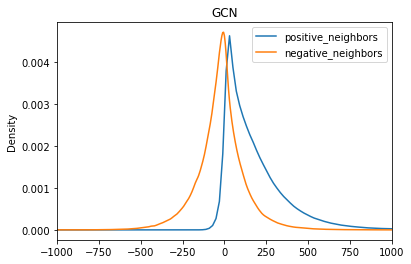

In [7]:
model = "GCN"
emb = np.load("../data/pokec_gcn_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape, plot_dot_(A, P, N, model_name=model)

In [8]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
edges.head()

100%|████████████████████████████████████████| 816/816 [00:12<00:00, 63.77it/s]


,source,target
0,0,7
1,0,3
2,0,2
3,0,103
4,0,0


In [9]:
scores[model] = statistical_parity(edges, y)

# GAT

100%|████████████████████████████| 1632803/1632803 [00:01<00:00, 891402.81it/s]


((1632803, 128), (1632803, 128), (1632803, 128), None)

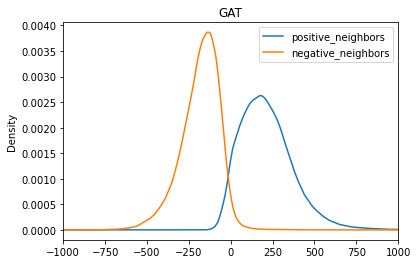

In [10]:
model = 'GAT'
emb = np.load("../data/pokec_gat_embs_fixed.npy")
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape, plot_dot_(A, P, N, model_name=model)

In [11]:
# # create edge_list
k, batch_size = 5, 2000

edges = get_edges_fastknn_faiss(A, k, batch_size,)
edges.head()

100%|████████████████████████████████████████| 816/816 [00:12<00:00, 63.04it/s]


,source,target
0,0,7
1,0,3
2,0,2
3,0,103
4,0,0


In [12]:
scores[model] = statistical_parity(edges, y)

# plot statistical parity scores

GCN 2.954101063524606e-06
GAT 2.9487619727297423e-06


[Text(0, 0, 'GCN'), Text(1, 0, 'GAT')]

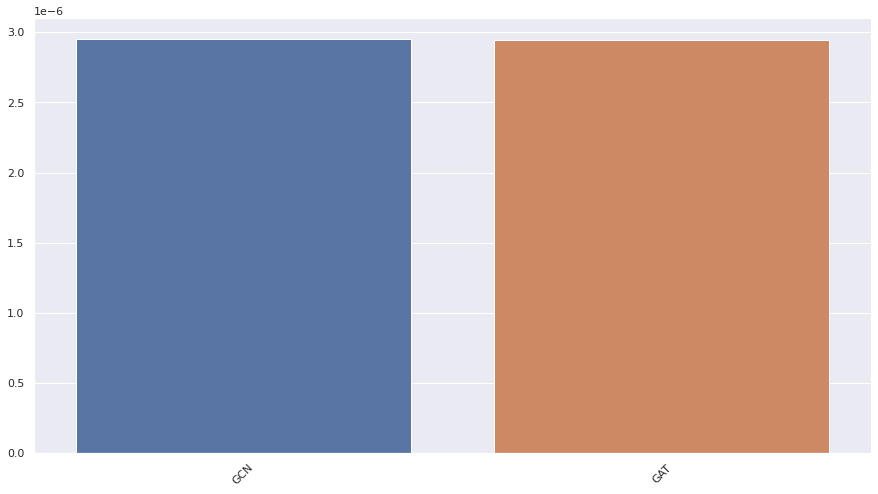

In [14]:
import seaborn as sns
for i, j in scores.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)